# Stock Prediction and Evaluation

In the page on [Cross-Sectional analysis](https://ledatascifi.github.io/ledatascifi-2025/content/05/05d_AssetPricingAnomalyTable1.html), step 2 is to "get your signal, then construct portfolio returns". For the purpose of that page, I just loaded some portfolio returns so that I could focus on show how we run the regression to do the analysis.

On _this page_, I'm going to show the "full stack" asset pricing toolkit:
1. We will build multiple machine learning models.
2. For each model, we will use rolling out-of-sample cross validation to see if the model would have made money trading over time. This has two parts:
   1. First, we train a model up to Dec 31, 2015, and then use it to predict returns throughout 2016. Then we repeat the training on Dec 31, 2016 and use the updated model to to predict returns throughout 2017, and so on... 
   2. Second, to assess whether a model would have made money, we compute the returns they generate if we use them to make a "long-short" portfolio: 
      1. We use the predictions as ``signals'' and sort stocks into 5 portfolios (or "bins"), where we think the stocks in bin 1 will do the worst and those in bin 5 the best. 
      2. We pretend that we buy the stocks in bin 5 (the "long") and short sell the stocks in bin 1 (the "short"). The short sells finance the buys, so this is a zero-cost portfolio. 
      3. This might sound complicated, but in the end, the monthly return of our long-short strategy is just the average return of stocks in bin 5 minus the average return of stocks in bin 1. So you might remember "long-short" as short for "long minus short".
3. For each model, we will subject its performance to a range of assessments. 

In [1]:
# Development mode flag - will use smaller datasets if True
DEV = False

# Standard library imports
import os
from datetime import datetime
import warnings
from functools import reduce

# Data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import gdown
from tqdm import tqdm
from ydata_profiling import ProfileReport
import openassetpricing as oap

# Statistical and machine learning
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Initialize OpenAP
openap = oap.OpenAP()

# Utility function to move columns to the front (left) of a dataframe
def move_column_to_front(df, columns):
    return df[columns + [col for col in df.columns if col not in columns]]

## Assemble data pieces


### Get return data

This is a permno-date dataset with returns from CRSP that I provided to students. 

The better method is to programmatically download the data from WRDS via the CRSP API, but this requires a WRDS login, which students do not usually have.

In [2]:
# This is a permno-date dataset with returns from CRSP. I provided it to students.
# Alternatively, we can download the data from WRDS via the CRSP API.

crsp = pd.read_csv('input_data/crsp_data.csv') 
crsp['date'] = pd.to_datetime(crsp['date'])
crsp.info()

# If we load more data, we should also load market value and stock price so we can filter 
# and do value weighted returns.

# for speedy dev, pick permnos at random (with seed)
if DEV == True:
    np.random.seed(123)
    
    # to ensure we have enough data, we will pick permnos that are in the dataset before 1990 and after 2020
    # but this will make our returns look artificially good because we are picking stocks that survive till 2020
    
    permnos = crsp['permno'].unique()
    permnos_before_1990 = crsp.query('date.dt.year < 1990')['permno'].unique()
    permnos_after_2020 = crsp.query('date.dt.year >= 2020')['permno'].unique()
    
    permnos = list(set(permnos_before_1990).intersection(set(permnos_after_2020)))
    permnos = np.random.choice(permnos, size=100, replace=False)
    crsp = crsp[crsp['permno'].isin(permnos)]
    
crsp.query('ret.notnull() and date.dt.year >= 1975', inplace=True)

# To merge with signals (a montly dataset, we will create a datetime column that is the 28th of the month)
# We pick the 28th of the month because it exists in all months 
crsp['date'] = pd.to_datetime(crsp['date'].dt.year*100 + crsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)
crsp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   permno  int64         
 1   date    datetime64[ns]
 2   ret     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 92.6 MB


,permno,date,ret
1,10000,1986-02-28,-25.7143
2,10000,1986-03-28,36.5385
3,10000,1986-04-28,-9.8592
4,10000,1986-05-28,-22.2656
5,10000,1986-06-28,-0.5025
...,...,...,...
4047625,93436,2024-08-28,-7.7391
4047626,93436,2024-09-28,22.1942
4047627,93436,2024-10-28,-4.5025
4047628,93436,2024-11-28,38.1469


### Some EDA

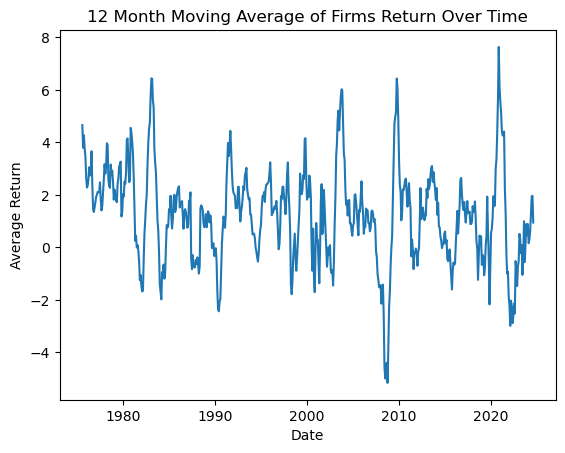

In [3]:
window = 12
sns.lineplot(data=(crsp
                  .groupby('date')['ret'].mean().reset_index()
                  .assign(returns_ma=lambda x: x['ret'].rolling(window=window, center=True).mean())
                  ),
             x='date', y='returns_ma').set(title=f'{window} Month Moving Average of Firms Return Over Time', xlabel='Date', ylabel='Average Return')
plt.show()

### Get Fama-French Factors

These are useful as predictors and also for performance evaluation after we construct our portfolios.

In [4]:
start = '1964-01-01' 
start_date = datetime.strptime(start, '%Y-%m-%d')

# Get FF5 and momentum
ff_5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date)[0]
ff_mom = pdr.get_data_famafrench('F-F_Momentum_Factor', start=start_date)[0]
ff_mom.columns = ['Mom'] # rename

# combine
ff_factors = pd.merge(ff_5, ff_mom, left_index=True, right_index=True, how='outer', indicator=True)
ff_factors = ff_factors.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})
ff_factors["date"] = ff_factors["date"].dt.to_timestamp()
ff_factors

# prep for merging with other datasets 
ff_factors["date"] = ff_factors["date"].apply(lambda x: x.replace(day=28)) # set to 28th of month for merging with crsp

# lagged version for predictive models 
ff_factors_lag = ff_factors.copy()
ff_factors_lag["date"] = ff_factors_lag["date"] - pd.DateOffset(months=1) # lag one month

### Download OAP signals zip file from Google Drive 

These 200+ signals are stock-level signals that research indicates predict future returns. 

The `openassetpricing` package can download all signals easily. But three of the signal variables (Price, Size, and STreversal) require a WRDS login, so we have to input a WRDS login or alternatively use the OAP download function and list all the predictors except those three. This file is [on their site](https://www.openassetpricing.com/data/) as a point and click download ([here](https://drive.google.com/drive/folders/1SSoHGbwgyhRwUCzLE0YWvUlS0DjLCd4k)). Let's use it. 

In [5]:
wide_signal_zipname = 'input_data/signed_predictors_dl_wide.zip'

if not os.path.exists(wide_signal_zipname):
    file_id = '1T-nogu88A4hcFXijjftSO41K5P4Hj27y'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, wide_signal_zipname, quiet=False)

### Open Signals from Zip

These signals are measured for each stock in a given month. We want to use them to predict returns in the _following_ month. So we want to merge these signals with the returns for the _following_ month. Example: The January 2010 signals should be merged with the February 2010 returns.

Thus, the most important part of below is that we create a new variable (`date`) that is the month following the signals measurement. We can use this variable to merge with the `crsp` dataset containing our returns.

In [6]:
if not DEV:
    signals = pd.read_csv('input_data/signed_predictors_dl_wide.zip')

elif DEV and os.path.exists('input_data/signed_predictors_dl_mini.csv'): # Just load the smaller version if it exists
    signals = pd.read_csv('input_data/signed_predictors_dl_mini.csv')

elif DEV and not os.path.exists('input_data/signed_predictors_dl_mini.csv'): # Load the big file and create a smaller version if needed
    signals = pd.read_csv('input_data/signed_predictors_dl_wide.zip')
    signals = signals[signals['permno'].isin(permnos)]
    signals.to_csv('input_data/signed_predictors_dl_mini.csv', index=False)
    
# rename yyyymm to signals so we avoid confusion
signals = signals.rename(columns={'yyyymm': 'yyyymm_signals'})

# Create date that is one month ahead for merging with returns
signals["yyyymm_signals"] = signals["yyyymm_signals"].astype(str) 
signals["date"] = pd.to_datetime(signals["yyyymm_signals"] + "28", format="%Y%m%d") + pd.DateOffset(months=1)
signals = move_column_to_front(signals, ['permno', 'date']) # lag signals by a month

rows_has_enough_signals = signals.notna().mean(axis=1) >= .1 # THRESHOLD REQUIREMENT: 10% of signals must be non-missing for a given row of data

print(f"Number of rows with enough signals: {rows_has_enough_signals.sum()} out of {len(rows_has_enough_signals)}")
print(f'Dropping {len(rows_has_enough_signals) - rows_has_enough_signals.sum()} ({(1-rows_has_enough_signals.mean())*100:.0f}%) rows with too many missing values.')
signals = signals[rows_has_enough_signals] # remove rows with too many missing values

signals

Number of rows with enough signals: 5003289 out of 5273600
Dropping 270311 (5%) rows with too many missing values.


,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
6,10000,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,2.065574
7,10000,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.909091e+00,4.032000
8,10000,1986-10-28,198609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.591646e-08,3.968504
9,10000,1986-11-28,198610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.225312e-08,3.937500
10,10000,1986-12-28,198611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.739130e+00,6.837210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273595,93436,2025-02-28,202501,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
5273596,93436,2025-03-28,202502,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
5273597,93436,2025-04-28,202503,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN
5273598,93436,2025-05-28,202504,NaN,NaN,-0.071498,0.043799,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.674801,NaN,NaN,NaN


### Merge all of the Datasets together

In [7]:
print(len(crsp))
crsp = crsp.merge(signals, on=['permno', 'date'], how='inner', validate="one_to_one") # INNER - require the firm to have some signals 
print(len(crsp))
crsp = crsp.merge(ff_factors_lag, on='date', how='left', validate="many_to_one")
print(len(crsp))

signal_list = crsp.columns[4:] # Create a list of signal columns to describe (this is signals from OAP + anything merged in)

3231490
3178156
3178156


## Set up Machine Learning (ML) training loop

### Open Documentation to Accurately Map Dtypes

In our machine learning models, we will want to treat continuous signal variables differently than categorical variables. OAP's documentation describes which variables are which kind.

In [8]:
signal_documentation = openap.dl_signal_doc('pandas')
signal_documentation

# need to find a way to add the column type from cat. form to match the acronyms which are the columns of the dataset
signaldoc = signal_documentation[['Acronym', 'Cat.Form']].drop_duplicates()
signaldoc

,Acronym,Cat.Form
0,AbnormalAccruals,continuous
1,Accruals,continuous
2,AccrualsBM,discrete
3,Activism1,continuous
4,AM,continuous
...,...,...
326,SP_q,continuous
327,tang_q,continuous
328,Tax_q,continuous
329,WW_Q,continuous


### ML preliminaries and set up

1. Split the data into X and y
2. Drop variables that are almost always missing
3. Split X and y into train and test. The test is the last few years, and is the holdout set. We want to minimize how often we evaluate our performance here (ideally: only once) to get a true model evaluation. 

In [9]:
# Split the data into X and y
X = crsp.drop(columns=['ret']) 
y = crsp['ret'] 
y_permno = crsp[['permno', 'ret']] # extra thing to save for later

# Drop variables that are almost always missing  
cutoff = .9
drop = X.isna().mean().sort_values(ascending=False) > cutoff # which variables are missing more than 90% of the time
drop = drop[drop].index.tolist() # get the names of the variables to drop

X = X.drop(columns=drop) # drop the columns that are not useful for prediction

# Convert to Float32 for better run times (less memory and faster runs)
float_cols = X.select_dtypes('float64').columns
X.loc[:, float_cols] = X.loc[:, float_cols].astype(np.float32, copy=False)

y = y.astype(np.float32)
y_permno = y_permno.astype(np.float32)

In [10]:
# del crsp # optional, free up memory

### Train/Validate and Test Split

In [11]:
# Split the data into train and test sets based on date
holdout_date = '2020-12-28'  # Define the split date

X_train = X[X['date'] <= holdout_date]
X_test = X[(X['date'] > holdout_date)]
y_train = y[X['date'] <= holdout_date]
y_test = y[(X['date'] > holdout_date)]

### EDA on the train data

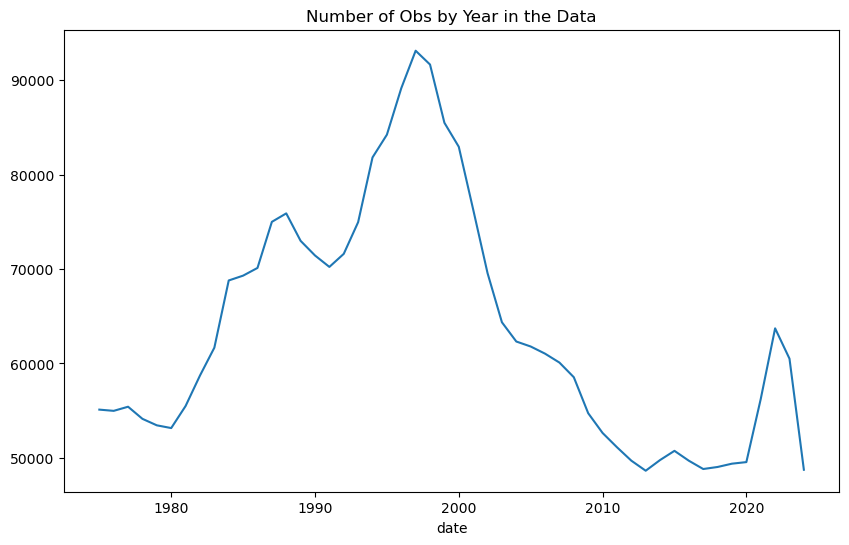

In [12]:
X_train
y_train
X['date'].dt.year.value_counts().sort_index().plot(kind='line', figsize=(10, 6)).set_title('Number of Obs by Year in the Data')
plt.show()

### More ML preliminaries

Cross sectional imputation (i.e. fill the missings with the average for a time period) is a good idea, per Chen et al JFE 2024. 
Above, we imported a customer class that lets us do that within pipelines. Note: It requires `X`/`X_train`/`X_test` to have `permno` and `date` in the index, not as variables. 

So here we do that.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class CrossSectionalMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute=None):
        self.features_to_impute = features_to_impute 

    def fit(self, X, y=None):
        # Nothing to fit — this imputer calculates means on the fly
        return self
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []

    def transform(self, X):
        X = X.copy()
        
        # Make sure it's a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CrossSectionalMeanImputer only works on pandas DataFrames")
        
        # Check if index is a MultiIndex with 'date' as one of the levels
        if not isinstance(X.index, pd.MultiIndex) or 'date' not in X.index.names:
            try:
                # add date to the index if it's not already there
                X = X.set_index(['permno','date'])
            except:
                raise ValueError("Input DataFrame must have a MultiIndex with 'date' as one of the levels")
        
        # Create a year variable
        X['_year'] = pd.to_datetime(X.index.get_level_values('date').year.values)
        
        # For each numeric column, fill NaNs with cross-sectional mean within each year
        # numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        if self.features_to_impute is not None:
            cols_to_impute = [col for col in self.features_to_impute if col in X.columns]
        else:
            cols_to_impute = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        for col in cols_to_impute:
            col_global_mean = X[col].mean()
            
            # If the global mean itself is NaN, fallback to 0
            if pd.isna(col_global_mean):
                col_global_mean = 0.0
            
            def safe_fill(x):
                if x.isnull().all():
                    return x.fillna(col_global_mean)  # use fallback global mean (guaranteed non-NaN now)
                else:
                    return x.fillna(x.mean())  # cross-sectional mean
                
            X[col] = X.groupby('_year')[col].transform(safe_fill)
            
        X = X.drop(columns=['_year'])
        
        return X


class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.0025, upper=0.9975):
        self.lower = lower
        self.upper = upper
    
    def fit(self, X, y=None):
        # Store quantiles for each column
        X_df = pd.DataFrame(X)
        self.lower_bounds_ = X_df.quantile(self.lower)
        self.upper_bounds_ = X_df.quantile(self.upper)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        for col in X_df.columns:
            X_df[col] = X_df[col].clip(lower=self.lower_bounds_[col],
                                       upper=self.upper_bounds_[col])
        return X_df.values  # return as numpy array for sklearn compatibility
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []


In [14]:
# This is necessary for the CrossSectionalMeanImputer to work
# (Else, the date variable will not be passed through the pipeline to this step, as it is not a numeric feature

X_train = X_train.set_index(['permno', 'date'])
X_test = X_test.set_index(['permno', 'date'])

### Set up the preprocessing pipeline

In [15]:
# columns to exclude from the training set 
exclude = ['ret', 'yyyymm_signals', 'permno', '_merge', 'sinAlgo'] 

# which variables are continuous and which are discrete?
# this is one way to do it, but note that this won't automatically update if you add your own variables to the dataset

continuous_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'continuous', 'Acronym'].tolist() + ['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'Mom'] # convert df to list to get columns for preprocessing pipe
discrete_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'discrete', 'Acronym'].tolist() # convert df to list to get columns for preprocessing pipe

# filter out columns that are not in X
continuous_cols = [col for col in continuous_cols if col in X.columns and col not in exclude] 
discrete_cols = [col for col in discrete_cols if col in X.columns and col not in exclude] 

# set up pipelines for each variable type
numer_pipe = make_pipeline(CrossSectionalMeanImputer(features_to_impute=continuous_cols), 
                           Winsorizer(lower=0.0025, upper=0.9975),
                           StandardScaler()) # use CrossSectionalMeanImputer to fill NaNs with cross-sectional mean within each year, then standardize the data and winsorize it

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                         OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 

# Create a ColumnTransformer to apply the pipelines to the appropriate columns
preproc_pipe = ColumnTransformer(
    transformers=[
        ('numbers', numer_pipe, continuous_cols),  
        ('categoricals', cat_pipe, discrete_cols), 
    ],
    remainder='drop'  
)

### Set up any non-default models types you want to try

In [16]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),  # 3 layers: 256 → 128 → 64 nodes does best with 3 hidden layers, should I reduce or increase the nodes?
    activation='relu',
    solver='adam',
    alpha=0.001,            # L2 penalty (like weight decay) to reduce overfitting
    batch_size=1000,
    learning_rate='adaptive',  # lowers learning rate when no improvement
    learning_rate_init=0.01,
    max_iter=100,
    early_stopping=True,   # Very important to avoid overfitting
    n_iter_no_change=5,  # Patience for early stopping    
    validation_fraction=0.1,  # 10% of training data used for validation internally
    random_state=42,
    # verbose=True           # See training progress
)

## Main training loop that generates out-of-sample predictions

For a list of models, train the model up to year t-1, then make predictions for year t. 

These out-of-sample predictions are used to build portfolios and evaluate their returns in the next section.

In [17]:
######## START: PARAMETERS #########

prediction_output_fname = 'predictions/prediction_output.csv'
force_rerun = False # set to True to force run all models again
    
# Create a Loop that goes by year instead of doing cv split function, trains up to year, validates and then expands trains and validates continued until end of training
model_dict = { 
    'OLS': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(), 
    'LassoCV': LassoCV(n_alphas=50, max_iter=2000, tol=0.001),
    'RidgeCV': RidgeCV(),
    'hgbr': HistGradientBoostingRegressor(),
    # 'mlp': mlp,
}

# Create a dictionary to store the parameters for the mlp regressor (hidden layer sizes from 1 to 5)
params = {
    'mlp': {'hidden_layer_sizes': [(64, 32),  (32, 16, 8), (128, 64, 32)]} # (128, 64, 32), (256, 128, 64, 32)] #, #(256, 128, 64, 32), (512, 256, 128, 64, 32)],
}

######## END: PARAMETERS #########

# Load existing predictions
os.makedirs(os.path.dirname(prediction_output_fname), exist_ok=True)
if os.path.exists(prediction_output_fname):
    prediction_output = pd.read_csv(prediction_output_fname)
    prediction_output['date'] = pd.to_datetime(prediction_output['date'])
    already_run_models = [c[5:] for c in prediction_output.columns if c.startswith('pred_')]
else:
    already_run_models = []
results = {}

# Loop through each model and its parameters
for model in model_dict.keys():
    print(f"\nTraining model: {model}")
    
    param_grid = params.get(model, {})
    for param in ParameterGrid(param_grid):
        print(f"Using parameters: {param}")
        
        # build a string for the model name based on the parameters
        if model == 'mlp':
            # Assume param is a dictionary like {'hidden_layer_sizes': (64, 32)}
            param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
            model_name = f"{model}_{param_suffix}"
        else:
            model_name = model  # Ridge, RF, etc, no param differentiation
                
        if model_name in already_run_models and not force_rerun:
            print(f"Model {model_name} already run. Skipping.")
            continue
                
        if model_name not in results:
            results[model_name] = []  # Initialize results for this model variant

        # Retrain the model each year, and validate on next year
        # Note: Below, we train up to year-1, and validate on year
   
        for year in tqdm(range(2000, 2020), desc="Training Years", unit="year"):
            X_train_year = X_train[X_train.index.get_level_values('date').year < year]
            y_train_year = y_train[X_train.index.get_level_values('date').year < year]
            
            X_val_year = X_train[X_train.index.get_level_values('date').year == year]
            y_val_year = y_train[X_train.index.get_level_values('date').year == year]
            
            model_pipe = make_pipeline(preproc_pipe, 
                                       model_dict[model].set_params(**param))
            model_pipe.fit(X_train_year, y_train_year)
            
            y_pred = model_pipe.predict(X_val_year) 
                        
            # Save predictions for this year
            results[model_name].append(pd.DataFrame({
                'permno': X_val_year.index.get_level_values('permno'),
                'date': X_val_year.index.get_level_values('date'),
                'ret': y_val_year.values,
                f'pred_{model_name}': y_pred,
            }))

# Concatenate and save the results:         
if len(results) > 0:            
    model_dfs = {
        model: pd.concat(df_list, ignore_index=True)
        for model, df_list in results.items()
    }

    # List of all model prediction DataFrames
    dfs = list(model_dfs.values())

    # Merge all on ['permno', 'date', 'ret']
    results_df = reduce(
        lambda left, right: pd.merge(left, right, on=['permno', 'date', 'ret'], how='outer'),
        dfs
    )

    results_df = results_df.drop_duplicates(subset=['permno', 'date'], keep='first')  # Keep the last occurrence of each permno-date pair
    results_df = results_df.sort_values(by=['date','permno']).reset_index(drop=True)  # Sort by permno and date

    # combine with already existing predictions
    if os.path.exists(prediction_output_fname):
        results_df = pd.merge(results_df, 
                            prediction_output, 
                            on=['permno', 'date'], how='outer', validate="one_to_one")

        # for any pair of columns with _x and _y, combine them (put ret_y where ret_x is null, rename ret_x, delete ret_y)
        col_pairs = [(col, col.replace('_x', '_y')) for col in results_df.columns if '_x' in col and col.replace('_x', '_y') in results_df.columns]
        for col_x, col_y in col_pairs:
            results_df[col_x] = results_df[col_x].combine_first(results_df[col_y])
            results_df.drop(columns=[col_y], inplace=True)
            results_df.rename(columns={col_x: col_x.replace('_x', '')}, inplace=True)
        
    results_df = move_column_to_front(results_df, ['permno', 'date', 'ret'])
    results_df.to_csv(prediction_output_fname, index=False)  # Save the results to a CSV file
    display(results_df)


Training model: OLS
Using parameters: {}


Training Years: 100%|██████████| 20/20 [33:10<00:00, 99.52s/year] 



Training model: Lasso
Using parameters: {}
Model Lasso already run. Skipping.

Training model: Ridge
Using parameters: {}
Model Ridge already run. Skipping.

Training model: LassoCV
Using parameters: {}
Model LassoCV already run. Skipping.

Training model: RidgeCV
Using parameters: {}
Model RidgeCV already run. Skipping.

Training model: hgbr
Using parameters: {}
Model hgbr already run. Skipping.


,permno,date,ret,pred_OLS,pred_Lasso,pred_Ridge,pred_LassoCV,pred_RidgeCV,pred_hgbr
0,10001,2000-01-28,-4.411800,3.813033,2.592113,3.813039,3.824155,3.813088,8.622208
1,10001,2000-02-28,1.538500,-2.361316,0.396361,-2.361310,-2.328464,-2.361258,-1.466668
2,10001,2000-03-28,-1.575800,0.441712,-0.369401,0.441706,0.370266,0.441658,-4.076953
3,10001,2000-04-28,1.171900,3.904848,1.700187,3.904846,3.880949,3.904827,1.198232
4,10001,2000-05-28,-2.316600,4.154211,4.137511,4.154218,4.168352,4.154280,1.924402
...,...,...,...,...,...,...,...,...,...
1151299,93436,2019-08-28,-6.622200,-1.781017,1.237719,-1.781020,-1.689892,-1.781040,0.525465
1151300,93436,2019-09-28,6.763900,-3.253841,1.237798,-3.253848,-3.220767,-3.253920,-1.497349
1151301,93436,2019-10-28,30.742701,-2.481885,1.239211,-2.481890,-2.568905,-2.481930,-1.832559
1151302,93436,2019-11-28,4.769500,-1.585509,1.243292,-1.585500,-1.420713,-1.585417,0.869092


Some speedy EDA of the predictions:

,permno,date,ret,pred_OLS,pred_Lasso,pred_Ridge,pred_LassoCV,pred_RidgeCV,pred_hgbr
0,10001,2000-01-28,-4.4118,3.813033,2.592113,3.813039,3.824155,3.813088,8.622208
1,10001,2000-02-28,1.5385,-2.361316,0.396361,-2.361310,-2.328464,-2.361258,-1.466668
2,10001,2000-03-28,-1.5758,0.441712,-0.369401,0.441706,0.370266,0.441658,-4.076953
3,10001,2000-04-28,1.1719,3.904848,1.700187,3.904846,3.880949,3.904827,1.198232
4,10001,2000-05-28,-2.3166,4.154211,4.137511,4.154218,4.168352,4.154280,1.924402
...,...,...,...,...,...,...,...,...,...
1151299,93436,2019-08-28,-6.6222,-1.781017,1.237719,-1.781020,-1.689892,-1.781040,0.525465
1151300,93436,2019-09-28,6.7639,-3.253841,1.237798,-3.253848,-3.220767,-3.253920,-1.497349
1151301,93436,2019-10-28,30.7427,-2.481885,1.239211,-2.481890,-2.568905,-2.481930,-1.832559
1151302,93436,2019-11-28,4.7695,-1.585509,1.243292,-1.585500,-1.420713,-1.585417,0.869092


,permno,date,ret,pred_OLS,pred_Lasso,pred_Ridge,pred_LassoCV,pred_RidgeCV,pred_hgbr
count,1.151304e+06,1151304,1.151304e+06,1.151304e+06,1.151304e+06,1.151304e+06,1.151304e+06,1.151304e+06,1.151304e+06
mean,6.684871e+04,2009-02-27 09:43:56.042609664,9.263928e-01,8.357270e-01,1.348494e+00,8.357256e-01,8.343737e-01,8.357134e-01,9.400993e-01
min,1.000100e+04,2000-01-28 00:00:00,-9.936000e+01,-2.680578e+01,-3.390984e+00,-2.680563e+01,-2.563256e+01,-2.680421e+01,-3.176544e+01
25%,4.762600e+04,2003-11-28 00:00:00,-6.809025e+00,-1.359106e+00,1.053138e+00,-1.359107e+00,-1.335894e+00,-1.359096e+00,-1.055972e+00
50%,8.076800e+04,2008-08-28 00:00:00,2.431500e-01,6.048324e-01,1.319144e+00,6.048245e-01,6.056659e-01,6.048291e-01,9.653463e-01
75%,8.747600e+04,2014-03-28 00:00:00,7.096800e+00,2.773002e+00,1.660821e+00,2.772993e+00,2.749800e+00,2.772937e+00,2.632306e+00
max,9.343600e+04,2019-12-28 00:00:00,1.988359e+03,4.418461e+01,6.219312e+00,4.418425e+01,4.222021e+01,4.418102e+01,1.673646e+02
std,2.844021e+04,NaN,1.909019e+01,3.577552e+00,8.641822e-01,3.577548e+00,3.537983e+00,3.577507e+00,4.246063e+00


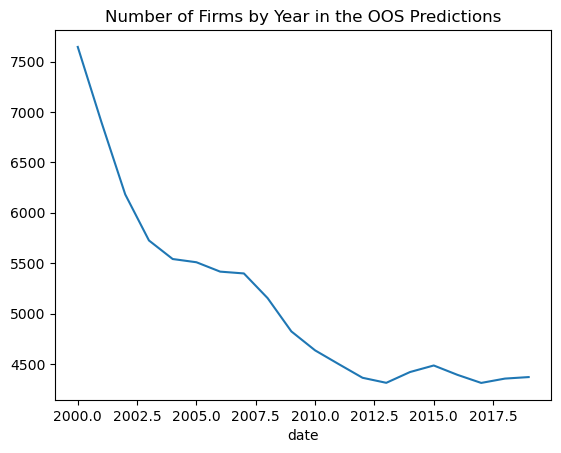

In [18]:
prediction_output = pd.read_csv(prediction_output_fname)
prediction_output['date'] = pd.to_datetime(prediction_output['date'])
prediction_output.groupby(prediction_output['date'].dt.year)['permno'].nunique().plot(kind='line').set_title('Number of Firms by Year in the OOS Predictions')
display(prediction_output)
print('\n\n')
display(prediction_output.describe())

## Make portfolios and determine portfolio returns

For a given model (column in the prediction df which are your new signals), compute the portfolio returns by sorting the predictions into quintiles or deciles and computing the average return of each decile.

In [19]:
prediction_output = pd.read_csv(prediction_output_fname)
prediction_output['date'] = pd.to_datetime(prediction_output['date'])

# convert returns to decimals 
prediction_output = (prediction_output.set_index(['permno', 'date'])/100).reset_index()
prediction_output

,permno,date,ret,pred_OLS,pred_Lasso,pred_Ridge,pred_LassoCV,pred_RidgeCV,pred_hgbr
0,10001,2000-01-28,-0.044118,0.038130,0.025921,0.038130,0.038242,0.038131,0.086222
1,10001,2000-02-28,0.015385,-0.023613,0.003964,-0.023613,-0.023285,-0.023613,-0.014667
2,10001,2000-03-28,-0.015758,0.004417,-0.003694,0.004417,0.003703,0.004417,-0.040770
3,10001,2000-04-28,0.011719,0.039048,0.017002,0.039048,0.038809,0.039048,0.011982
4,10001,2000-05-28,-0.023166,0.041542,0.041375,0.041542,0.041684,0.041543,0.019244
...,...,...,...,...,...,...,...,...,...
1151299,93436,2019-08-28,-0.066222,-0.017810,0.012377,-0.017810,-0.016899,-0.017810,0.005255
1151300,93436,2019-09-28,0.067639,-0.032538,0.012378,-0.032538,-0.032208,-0.032539,-0.014973
1151301,93436,2019-10-28,0.307427,-0.024819,0.012392,-0.024819,-0.025689,-0.024819,-0.018326
1151302,93436,2019-11-28,0.047695,-0.015855,0.012433,-0.015855,-0.014207,-0.015854,0.008691


In [20]:
model_names = [c[5:] for c in prediction_output.columns if c.startswith('pred_')]
model_names

['OLS', 'Lasso', 'Ridge', 'LassoCV', 'RidgeCV', 'hgbr']

In [21]:
def port_sort(x, nport):
    return np.ceil(x.rank(method="min") * nport / (len(x) + 1)).astype(int)

def calculate_portfolio_stats(df, model_names, nport=5, timegroup='date'):
    '''
    Assumes that the input dataframe has a column 'ret' for returns 
    and that the model predictions for a firm's return in a given month
    is in columns named 'pred_<modelname>'.
    '''
    
    from functools import reduce
    
    returns = []
    port_stats = []
    for model in model_names:
        prediction_output[f'port_{model}'] = prediction_output.groupby(timegroup)[f'pred_{model}'].transform(lambda x: port_sort(x, nport)) # create decile portfolios based on the model predictions
        print(f'\n\nForming portfolios for {model}, and assignments to bins are:')
        display(prediction_output[f'port_{model}'].value_counts().sort_index()) 
        
        # wide format for returns
        this_port_rets_wide = prediction_output.pivot_table(
                index='date',
                columns=[f'port_{model}'],
                values='ret',
                aggfunc='mean'
            ).reset_index().set_index('date')

        this_port_rets_wide['LS'] = this_port_rets_wide.iloc[:, -1] - this_port_rets_wide.iloc[:, 0]
        this_port_rets_wide.columns = [f'ret_{model}_bin{c}' for c in this_port_rets_wide.columns]
        returns.append(this_port_rets_wide)
        
        # long format for portfolio stats
        this_port_stats_long = (prediction_output
                                .groupby([f'port_{model}', 'date'])
                                .agg({'ret': ['mean','std','count']})
        ).reset_index()
        this_port_stats_long.columns = ['bin', 'date', 'ret', 'std', 'nfirms']
        this_port_stats_long['model'] = model
        this_port_stats_long = move_column_to_front(this_port_stats_long, ['model', 'bin', 'date'])
        port_stats.append(this_port_stats_long)
        
    # Combine all dfs in returns into one df
    returns_wide_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), returns)

    # Concatenate all portfolio stats into one df
    port_stats_tall_df = pd.concat(port_stats, ignore_index=True)
    
    return returns_wide_df, port_stats_tall_df, prediction_output

In [22]:
returns_wide_df, port_stats_tall_df, prediction_output = calculate_portfolio_stats(prediction_output, model_names, nport=5)



Forming portfolios for OLS, and assignments to bins are:


port_OLS
1    230214
2    230309
3    230305
4    230309
5    230167
Name: count, dtype: int64



Forming portfolios for Lasso, and assignments to bins are:


port_Lasso
1    338719
2    221642
3    217617
4    213760
5    159566
Name: count, dtype: int64



Forming portfolios for Ridge, and assignments to bins are:


port_Ridge
1    230214
2    230309
3    230305
4    230309
5    230167
Name: count, dtype: int64



Forming portfolios for LassoCV, and assignments to bins are:


port_LassoCV
1    230214
2    230309
3    230305
4    230309
5    230167
Name: count, dtype: int64



Forming portfolios for RidgeCV, and assignments to bins are:


port_RidgeCV
1    230214
2    230309
3    230305
4    230309
5    230167
Name: count, dtype: int64



Forming portfolios for hgbr, and assignments to bins are:


port_hgbr
1    230215
2    230311
3    230302
4    230310
5    230166
Name: count, dtype: int64

In [23]:
tall_fname = 'output_portfolios/port_stats_tall.csv'
ret_wide_fname = 'output_portfolios/returns_wide.csv'
os.makedirs(os.path.dirname(tall_fname), exist_ok=True)

port_stats_tall_df.to_csv(tall_fname, index=False)
returns_wide_df.to_csv(ret_wide_fname, index=True)

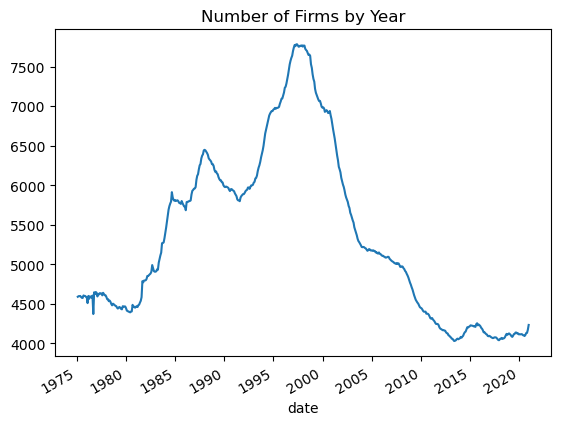

In [24]:
X_train.reset_index().groupby('date')['permno'].nunique().plot(kind='line').set_title('Number of Firms by Year')
plt.show()

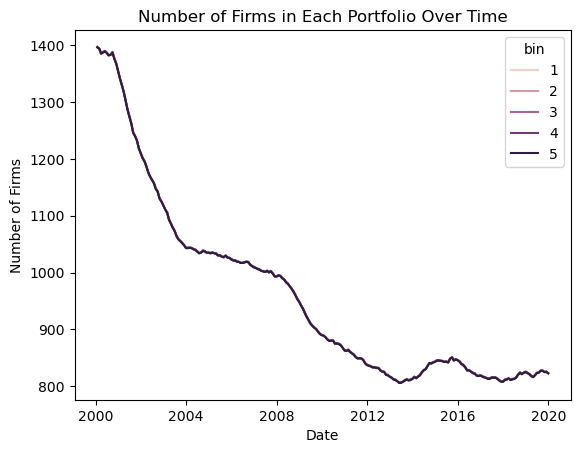

In [25]:
sns.lineplot(data=port_stats_tall_df.query('model=="LassoCV"'), hue='bin', x='date', y='nfirms'
            ).set(title='Number of Firms in Each Portfolio Over Time', xlabel='Date', ylabel='Number of Firms')
plt.show()

## Portfolio Analysis

### "Table 1" Results, for each portfolio

In [26]:
def table_1(df, model_tag):
    portfolios = df.filter(like=model_tag).columns.tolist()

    df = df.filter(like=model_tag)*100 # convert to percent
    reg_df = df.merge(
        ff_factors
        .set_index('date'), 
        left_index=True, right_index=True, how='left'
    )
    
    # define factor model formulas (these are the right side of the regrssion formulas)
    # these are how formulas are specified for statsmodel's formula api
    factor_models = {
        'r^e':  '1',
        'CAPM': 'mkt_excess',
        'FF3':  'mkt_excess + SMB + HML',
        'FF4':  'mkt_excess + SMB + HML + Mom',
        'FF5':  'mkt_excess + SMB + HML + RMW + CMA',
        'FF6':  'mkt_excess + SMB + HML + RMW + CMA + Mom'
    }
    
    # pre built output table
    index = pd.MultiIndex.from_product([factor_models.keys(), ['alpha', 't-stat']], names=['Model', 'Metric'])
    results = pd.DataFrame(index=index, columns=portfolios, dtype=float)
    
    # Run regressions for each portfolio and model
    full_reg_outout = {} # to save everything, in case we want to access other stuff (like beta loadings)
    for portfolio in portfolios:
        reg_df[portfolio] = reg_df[portfolio] - reg_df['RF'] # excess returns    
        for model_name, formula in factor_models.items():
            reg = smf.ols(formula=f'{portfolio} ~ {formula}', data=reg_df).fit()
            # extract the intercept coef and t-stat
            alpha = reg.params['Intercept']
            t_stat = reg.tvalues['Intercept']
            results.at[(model_name, 'alpha'), portfolio] = alpha
            results.at[(model_name, 't-stat'), portfolio] = t_stat
            full_reg_outout[(model_name, portfolio)] = reg

    return results

In [27]:
table_1s = {}
for model in model_names:
    print(f'\n\nModel: {model}')
    table_1s[model] = table_1(returns_wide_df, model)
    display(table_1s[model])
    print('\n\n')



Model: OLS


ret_OLS_bin1  ret_OLS_bin2  ret_OLS_bin3  ret_OLS_bin4  \
Model Metric                                                           
r^e   alpha      -0.396842      0.437042      0.729036      1.120041   
      t-stat     -0.899928      1.203779      2.129111      3.128598   
CAPM  alpha      -1.036170     -0.110436      0.209986      0.593735   
      t-stat     -4.590918     -0.679722      1.400643      3.380452   
FF3   alpha      -1.163077     -0.248823      0.069800      0.449934   
      t-stat     -7.154595     -2.390019      0.708598      3.535420   
FF4   alpha      -1.075724     -0.190714      0.136032      0.541487   
      t-stat     -7.153319     -1.994720      1.576614      4.973897   
FF5   alpha      -0.931338     -0.143665      0.129317      0.517360   
      t-stat     -5.687613     -1.342329      1.259235      3.877110   
FF6   alpha      -0.900421     -0.122221      0.154942      0.553322   
      t-stat     -5.886771     -1.234457      1.715721      4.837923   

              ret_OLS_bin5  ret_OLS_binLS  
Model Metric                               
r^e   alpha       2.182189       2.444281  
      t-stat      4.416922       9.889894  
CAPM  alpha       1.551175       2.450147  
      t-stat      4.783360       9.835747  
FF3   alpha       1.396974       2.425228  
      t-stat      5.056189       9.669736  
FF4   alpha       1.600325       2.541548  
      t-stat      6.832562      10.707626  
FF5   alpha       1.695340       2.494094  
      t-stat      6.193522      10.006149  
FF6   alpha       1.774019       2.541936  
      t-stat      7.760661      10.945537






Model: Lasso


ret_Lasso_bin1  ret_Lasso_bin2  ret_Lasso_bin3  ret_Lasso_bin4  \
Model Metric                                                                   
r^e   alpha         0.187110        0.874743        0.944596        1.132171   
      t-stat        0.446547        1.619199        1.866165        2.596875   
CAPM  alpha        -0.423412        0.114879        0.663855        0.646937   
      t-stat       -2.003285        0.354065        1.956569        2.465857   
FF3   alpha        -0.527489       -0.063952        0.273819        0.607821   
      t-stat       -2.990592       -0.219625        0.920990        2.991432   
FF4   alpha        -0.457517        0.063030        0.345572        0.697581   
      t-stat       -2.694197        0.246813        1.277999        3.735616   
FF5   alpha        -0.311509        0.232993        0.425264        0.797578   
      t-stat       -1.739454        0.784618        1.361327        3.852013   
FF6   alpha        -0.287552        0.256734        0.401894        0.774250   
      t-stat       -1.657257        0.981070        1.407350        4.047685   

              ret_Lasso_bin5  ret_Lasso_binLS  ret_LassoCV_bin1  \
Model Metric                                                      
r^e   alpha         1.491512         1.056042         -0.400796   
      t-stat        3.149670         3.032132         -0.907759   
CAPM  alpha         0.920639         1.108576         -1.041891   
      t-stat        2.672148         3.167370         -4.630675   
FF3   alpha         0.612280         0.962214         -1.167168   
      t-stat        2.092029         2.770423         -7.245460   
FF4   alpha         0.735807         1.008374         -1.081472   
      t-stat        2.605189         2.894916         -7.244203   
FF5   alpha         0.780330         0.946306         -0.932588   
      t-stat        2.680928         2.705235         -5.757843   
FF6   alpha         0.844287         0.974171         -0.902388   
      t-stat        3.026517         2.791490         -5.953278   

              ret_LassoCV_bin2  ret_LassoCV_bin3  ret_LassoCV_bin4  \
Model Metric                                                         
r^e   alpha           0.426757          0.754761          1.110075   
      t-stat          1.170084          2.207443          3.111516   
CAPM  alpha          -0.122221          0.236764          0.584850   
      t-stat         -0.743277          1.577633          3.356691   
FF3   alpha          -0.261635          0.096369          0.442432   
      t-stat         -2.461251          0.984260          3.472174   
FF4   alpha          -0.201925          0.162727          0.532740   
      t-stat         -2.071065          1.902323          4.860188   
FF5   alpha          -0.157327          0.154760          0.509339   
      t-stat         -1.439028          1.515889          3.811998   
FF6   alpha          -0.135239          0.180458          0.544833   
      t-stat         -1.339144          2.015398          4.732670   

              ret_LassoCV_bin5  ret_LassoCV_binLS  
Model Metric                                       
r^e   alpha           2.180678           2.446724  
      t-stat          4.413533           9.858009  
CAPM  alpha           1.550798           2.455492  
      t-stat          4.769732           9.816799  
FF3   alpha           1.394823           2.427168  
      t-stat          5.035259           9.641610  
FF4   alpha           1.599347           2.546318  
      t-stat          6.819418          10.716935  
FF5   alpha           1.692840           2.492845  
      t-stat          6.161145           9.940262  
FF6   alpha           1.771987           2.541871  
      t-stat          7.730082          10.910971






Model: Ridge


ret_Ridge_bin1  ret_Ridge_bin2  ret_Ridge_bin3  ret_Ridge_bin4  \
Model Metric                                                                   
r^e   alpha        -0.396601        0.436800        0.729036        1.120041   
      t-stat       -0.899387        1.203123        2.129111        3.128598   
CAPM  alpha        -1.035941       -0.110665        0.209986        0.593735   
      t-stat       -4.590275       -0.681094        1.400643        3.380452   
FF3   alpha        -1.162827       -0.249072        0.069800        0.449934   
      t-stat       -7.153905       -2.392348        0.708598        3.535420   
FF4   alpha        -1.075478       -0.190961        0.136032        0.541487   
      t-stat       -7.152629       -1.997249        1.576614        4.973897   
FF5   alpha        -0.931161       -0.143841        0.129317        0.517360   
      t-stat       -5.687078       -1.343995        1.259235        3.877110   
FF6   alpha        -0.900244       -0.122398        0.154942        0.553322   
      t-stat       -5.886269       -1.236258        1.715721        4.837923   

              ret_Ridge_bin5  ret_Ridge_binLS  ret_RidgeCV_bin1  \
Model Metric                                                      
r^e   alpha         2.182189         2.444040         -0.396701   
      t-stat        4.416922         9.889286         -0.899626   
CAPM  alpha         1.551175         2.449918         -1.036023   
      t-stat        4.783360         9.835198         -4.590459   
FF3   alpha         1.396974         2.424978         -1.162920   
      t-stat        5.056189         9.669139         -7.154258   
FF4   alpha         1.600325         2.541302         -1.075571   
      t-stat        6.832562        10.707130         -7.152993   
FF5   alpha         1.695340         2.493917         -0.931219   
      t-stat        6.193522        10.005771         -5.687325   
FF6   alpha         1.774019         2.541759         -0.900303   
      t-stat        7.760661        10.945189         -5.886509   

              ret_RidgeCV_bin2  ret_RidgeCV_bin3  ret_RidgeCV_bin4  \
Model Metric                                                         
r^e   alpha           0.436818          0.729004          1.120688   
      t-stat          1.203146          2.129029          3.130316   
CAPM  alpha          -0.110668          0.209964          0.594343   
      t-stat         -0.681145          1.400419          3.384323   
FF3   alpha          -0.249066          0.069778          0.450575   
      t-stat         -2.392430          0.708352          3.540975   
FF4   alpha          -0.190952          0.135988          0.542091   
      t-stat         -1.997318          1.575875          4.979671   
FF5   alpha          -0.143863          0.129276          0.518037   
      t-stat         -1.344265          1.258809          3.882774   
FF6   alpha          -0.122418          0.154892          0.553984   
      t-stat         -1.236550          1.714943          4.843958   

              ret_RidgeCV_bin5  ret_RidgeCV_binLS  
Model Metric                                       
r^e   alpha           2.181656           2.443608  
      t-stat          4.415945           9.887435  
CAPM  alpha           1.550673           2.449499  
      t-stat          4.781750           9.833416  
FF3   alpha           1.396441           2.424538  
      t-stat          5.054070           9.667282  
FF4   alpha           1.599847           2.540917  
      t-stat          6.830933          10.706047  
FF5   alpha           1.694783           2.493419  
      t-stat          6.191159          10.003554  
FF6   alpha           1.773485           2.541284  
      t-stat          7.758738          10.943722






Model: LassoCV


ret_LassoCV_bin1  ret_LassoCV_bin2  ret_LassoCV_bin3  \
Model Metric                                                         
r^e   alpha          -0.400796          0.426757          0.754761   
      t-stat         -0.907759          1.170084          2.207443   
CAPM  alpha          -1.041891         -0.122221          0.236764   
      t-stat         -4.630675         -0.743277          1.577633   
FF3   alpha          -1.167168         -0.261635          0.096369   
      t-stat         -7.245460         -2.461251          0.984260   
FF4   alpha          -1.081472         -0.201925          0.162727   
      t-stat         -7.244203         -2.071065          1.902323   
FF5   alpha          -0.932588         -0.157327          0.154760   
      t-stat         -5.757843         -1.439028          1.515889   
FF6   alpha          -0.902388         -0.135239          0.180458   
      t-stat         -5.953278         -1.339144          2.015398   

              ret_LassoCV_bin4  ret_LassoCV_bin5  ret_LassoCV_binLS  
Model Metric                                                         
r^e   alpha           1.110075          2.180678           2.446724  
      t-stat          3.111516          4.413533           9.858009  
CAPM  alpha           0.584850          1.550798           2.455492  
      t-stat          3.356691          4.769732           9.816799  
FF3   alpha           0.442432          1.394823           2.427168  
      t-stat          3.472174          5.035259           9.641610  
FF4   alpha           0.532740          1.599347           2.546318  
      t-stat          4.860188          6.819418          10.716935  
FF5   alpha           0.509339          1.692840           2.492845  
      t-stat          3.811998          6.161145           9.940262  
FF6   alpha           0.544833          1.771987           2.541871  
      t-stat          4.732670          7.730082          10.910971






Model: RidgeCV


ret_RidgeCV_bin1  ret_RidgeCV_bin2  ret_RidgeCV_bin3  \
Model Metric                                                         
r^e   alpha          -0.396701          0.436818          0.729004   
      t-stat         -0.899626          1.203146          2.129029   
CAPM  alpha          -1.036023         -0.110668          0.209964   
      t-stat         -4.590459         -0.681145          1.400419   
FF3   alpha          -1.162920         -0.249066          0.069778   
      t-stat         -7.154258         -2.392430          0.708352   
FF4   alpha          -1.075571         -0.190952          0.135988   
      t-stat         -7.152993         -1.997318          1.575875   
FF5   alpha          -0.931219         -0.143863          0.129276   
      t-stat         -5.687325         -1.344265          1.258809   
FF6   alpha          -0.900303         -0.122418          0.154892   
      t-stat         -5.886509         -1.236550          1.714943   

              ret_RidgeCV_bin4  ret_RidgeCV_bin5  ret_RidgeCV_binLS  
Model Metric                                                         
r^e   alpha           1.120688          2.181656           2.443608  
      t-stat          3.130316          4.415945           9.887435  
CAPM  alpha           0.594343          1.550673           2.449499  
      t-stat          3.384323          4.781750           9.833416  
FF3   alpha           0.450575          1.396441           2.424538  
      t-stat          3.540975          5.054070           9.667282  
FF4   alpha           0.542091          1.599847           2.540917  
      t-stat          4.979671          6.830933          10.706047  
FF5   alpha           0.518037          1.694783           2.493419  
      t-stat          3.882774          6.191159          10.003554  
FF6   alpha           0.553984          1.773485           2.541284  
      t-stat          4.843958          7.758738          10.943722






Model: hgbr


ret_hgbr_bin1  ret_hgbr_bin2  ret_hgbr_bin3  ret_hgbr_bin4  \
Model Metric                                                               
r^e   alpha       -0.258377       0.518116       0.737424       1.031638   
      t-stat      -0.526859       1.423428       2.260950       2.933390   
CAPM  alpha       -0.933969      -0.025011       0.240107       0.520235   
      t-stat      -3.289316      -0.147404       1.725757       2.915284   
FF3   alpha       -1.091146      -0.170813       0.116438       0.389359   
      t-stat      -4.818754      -1.441349       1.185496       2.917948   
FF4   alpha       -0.960665      -0.103874       0.158506       0.462126   
      t-stat      -4.650424      -0.956737       1.689138       3.754148   
FF5   alpha       -0.818076      -0.113557       0.111006       0.452766   
      t-stat      -3.533644      -0.915463       1.073976       3.232417   
FF6   alpha       -0.770086      -0.087601       0.128082       0.481169   
      t-stat      -3.618091      -0.769541       1.303557       3.721329   

              ret_hgbr_bin5  ret_hgbr_binLS  
Model Metric                                 
r^e   alpha        2.042630        2.166258  
      t-stat       4.048139        6.700320  
CAPM  alpha        1.406859        2.203631  
      t-stat       4.172482        6.777704  
FF3   alpha        1.260885        2.217209  
      t-stat       4.357800        6.761005  
FF4   alpha        1.455241        2.281405  
      t-stat       5.740275        6.986733  
FF5   alpha        1.634828        2.320320  
      t-stat       5.665505        6.807307  
FF6   alpha        1.708035        2.345618  
      t-stat       6.765534        6.934035

### Returns plot

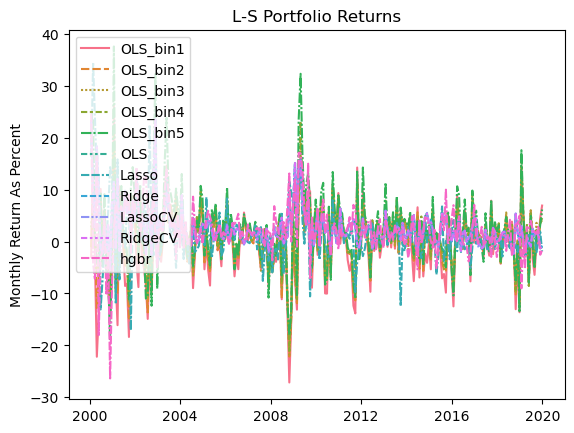

In [28]:
plot_df = returns_wide_df.filter(like='LS')*100
plot_df.columns = [c.replace('ret_', '').replace('_binLS','') for c in plot_df.columns]
sns.lineplot(plot_df
             ).set(title=f'L-S Portfolio Returns', 
                   xlabel='', 
                   ylabel=f'Monthly Return As Percent')
plt.show()

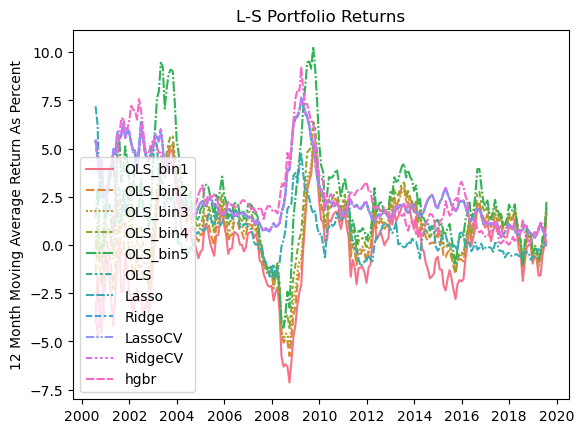

In [29]:
window = 12
plot_df = returns_wide_df.filter(like='LS').fillna(0)*100 # Don't let Lasso's months with no firms in bin5 affect the rolling mean
plot_df.columns = [c.replace('ret_', '').replace('_binLS','') for c in plot_df.columns]
sns.lineplot(plot_df.rolling(window=window, center=True).mean()
             ).set(title=f'L-S Portfolio Returns', 
                   xlabel='', 
                   ylabel=f'{window} Month Moving Average Return As Percent')
plt.show()

### Cumulative returns plot

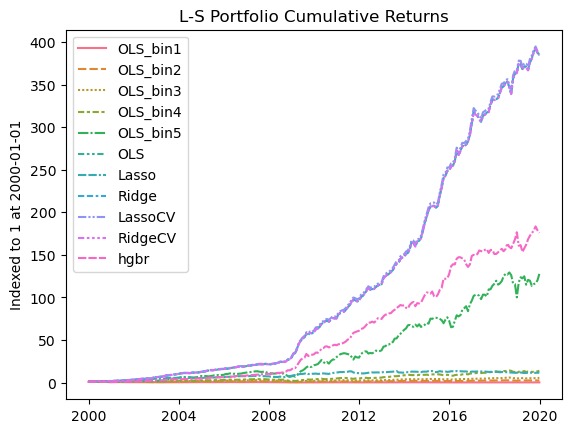

In [30]:
window = 12
plot_df = (1+returns_wide_df.filter(like='LS')).cumprod()
# add a month before the first date and set values to one for the first month
row1 = pd.DataFrame(index=[plot_df.index[0] - pd.DateOffset(months=1)], data={c:[1] for c in plot_df.columns})
plot_df = pd.concat([row1, plot_df])

# now plot
plot_df.columns = [c.replace('ret_', '').replace('_binLS','') for c in plot_df.columns]
sns.lineplot(plot_df).set(title=f'L-S Portfolio Cumulative Returns', 
                   xlabel='', 
                   ylabel=f'Indexed to 1 at {plot_df.index[1].strftime("%Y-%m-01")}')
plt.show()

In [31]:
# compute out of sample sharpe ratios for the long-short portfolios
# no need to remove RF rate with long-short portfolios, as they are 
# self financing 
sharpe_ratios = (returns_wide_df.filter(like='LS').mean() / returns_wide_df.filter(like='LS').std()) * np.sqrt(12) # annualize the sharpe ratio
sharpe_ratios

ret_OLS_bin1        -0.133226
ret_OLS_bin2         0.353170
ret_OLS_bin3         0.565225
ret_OLS_bin4         0.785372
ret_OLS_bin5         1.050015
ret_OLS_binLS        2.329327
ret_Lasso_binLS      0.775328
ret_Ridge_binLS      2.329191
ret_LassoCV_binLS    2.321645
ret_RidgeCV_binLS    2.328793
ret_hgbr_binLS       1.598343
dtype: float64

## Save turnover metrics by portfolio

In [32]:
import warnings

# — assume you already have this from your last step —
turnover_df = prediction_output.copy() \
              .sort_values(['permno','date']) \
              .set_index(['permno','date'])

# 1. identify which cols are your “port_…” assignments
port_cols = [c for c in turnover_df.columns if c.startswith('port_')]

# 2. build a little DataFrame for each (model,port) that has %buy, %sell, %hold by date
all_stats = []

print('Note: "RuntimeWarning: invalid value encountered in scalar divide" is expected here.')
print('It is bc some models, e.g. Lasso, sometimes have no stocks in one of the bin portfolios.')
print('To make this code prettier, I suppress the warnings. But this is often a mistake/sign of a problem.')

for col in port_cols:
    # model name is whatever follows “port_”
    model = col.split('_',1)[1]
    # what portfolios (1,2,3,…) actually appear?
    ports = sorted(turnover_df[col].dropna().unique())

    for p in ports:
        # boolean series: is this stock in bucket p at this date?
        curr = turnover_df[col].eq(p)
        # same thing, lagged one month _within_ each permno
        prev = turnover_df.groupby(level='permno')[col].shift(1).eq(p)

        # pack into a helper DF so we can group by date
        tmp = pd.DataFrame({'curr': curr, 'prev': prev})

        # now for each date compute the three rates
        with warnings.catch_warnings():
            # this is a bit of a hack, but it’s the only way to get rid of the warning
            # and the warning is not relevant to the analysis
            warnings.simplefilter("ignore", RuntimeWarning)
            stats = (
                tmp
                .groupby(level='date')
                .apply(lambda g: pd.Series({
                    '% buy' :  (g['curr']  & ~g['prev']).sum() / ((g['curr']|g['prev']).sum()),
                    '% sell':  (~g['curr'] &  g['prev']).sum() / ((g['curr']|g['prev']).sum()),
                    '% hold':  (g['curr']  &  g['prev']).sum() / ((g['curr']|g['prev']).sum()),
                }))
                .reset_index()
            )

        stats['model'] = model
        stats['bin' ] = p

        all_stats.append(stats)

# 3. stitch them all together and pick your column order
turnover_df = (
    pd.concat(all_stats, ignore_index=True)
      [['model','bin','date','% buy','% sell','% hold']]
      .sort_values(['model','bin','date'])
)

# voilà:
turnover_df.to_csv('output_portfolios/turnover.csv', index=False)
turnover_df


Note: "RuntimeWarning: invalid value encountered in scalar divide" is expected here.
It is bc some models, e.g. Lasso, sometimes have no stocks in one of the bin portfolios.
To make this code prettier, I suppress the warnings. But this is often a mistake/sign of a problem.


,model,bin,date,% buy,% sell,% hold
1200,Lasso,1,2000-01-28,1.000000,0.000000,0.000000
1201,Lasso,1,2000-02-28,0.243968,0.088472,0.667560
1202,Lasso,1,2000-03-28,0.133540,0.195135,0.671325
1203,Lasso,1,2000-04-28,0.470730,0.521006,0.008264
1204,Lasso,1,2000-05-28,0.277254,0.264675,0.458071
...,...,...,...,...,...,...
7195,hgbr,5,2019-08-28,0.396628,0.393695,0.209677
7196,hgbr,5,2019-09-28,0.430257,0.426093,0.143650
7197,hgbr,5,2019-10-28,0.390983,0.390244,0.218773
7198,hgbr,5,2019-11-28,0.348689,0.344718,0.306593


In [33]:
# present decimals as % via styler
turnover_df.set_index(['model','bin']).filter(like='%').groupby(level=['model','bin']).mean().round(2).style.format(
    {'% buy': '{:.2%}', '% sell': '{:.2%}', '% hold': '{:.2%}'},
    na_rep='-'
).set_caption('Average Turnover by Portfolio and Model')

## Model Output - Save model objects to display coefficients for dashboard

In [ ]:
# Loop through each model and its parameters
trained_models = []
for model in model_dict.keys():
    print(f"\nTraining model: {model}")
    
    param_grid = params.get(model, {})
    for param in ParameterGrid(param_grid):
        print(f"Using parameters: {param}")
        
        # build a string for the model name based on the parameters
        if model == 'mlp':
            # Assume param is a dictionary like {'hidden_layer_sizes': (64, 32)}
            param_suffix = "_".join(str(x) for x in param['hidden_layer_sizes'])
            model_name = f"{model}_{param_suffix}"
        else:
            model_name = model  # Ridge, RF, etc, no param differentiation
        
        if os.path.exists(f'models/{model_name}.joblib'):
            print(f"Saved output for {model_name} already exists. Skipping.")
            continue
        
        year = 2020
        
        X_train_year = X_train[X_train.index.get_level_values('date').year < year]
        y_train_year = y_train[X_train.index.get_level_values('date').year < year]
        
        X_val_year = X_train[X_train.index.get_level_values('date').year == year]
        y_val_year = y_train[X_train.index.get_level_values('date').year == year]
        
        model_pipe = make_pipeline(preproc_pipe, 
                                    model_dict[model].set_params(**param))
        model_pipe.fit(X_train_year, y_train_year)
        
        trained_models.append((model_name, model_pipe))




Training model: OLS
Using parameters: {}

Training model: Lasso
Using parameters: {}

Training model: Ridge
Using parameters: {}

Training model: LassoCV
Using parameters: {}

Training model: RidgeCV
Using parameters: {}

Training model: hgbr
Using parameters: {}


In [35]:
import joblib

os.makedirs('models', exist_ok=True)

for model_name, model_pipe in trained_models:
    joblib.dump(model_pipe, f'models/{model_name}.joblib')
    print(f'Model {model_name} saved to models/{model_name}.joblib') 

Model OLS saved to models/OLS.joblib
Model Lasso saved to models/Lasso.joblib
Model Ridge saved to models/Ridge.joblib
Model LassoCV saved to models/LassoCV.joblib
Model RidgeCV saved to models/RidgeCV.joblib
Model hgbr saved to models/hgbr.joblib
